# Part II Project Notebook

## Extraction of Normal Modes and Plotting

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from src.ProDyNMA import calculate_modes_gnm_cpu,calculate_modes_anm_cpu

calculate_modes_gnm_cpu("1A0A")
calculate_modes_anm_cpu("1A0A")

C:\Users\Mihailo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\Bio\pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(
@> PDB file is found in working directory (1a0a.pdb).
@> 1767 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> Kirchhoff was built in 0.00s.
@> 20 modes were calculated in 0.03s.
@> PDB file is found in working directory (1a0a.pdb).
@> 1767 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> Hessian was built in 0.01s.
@> WARNING More than 6 (18) zero eigenvalues were calculated.
@> Solving for additional eigenvalues...
@> 20 modes were calculated in 0.17s.


(array([0.00011417, 0.00012049, 0.00040389, 0.0007291 , 0.00105616,
        0.00250762, 0.00256584, 0.00286281, 0.00364844, 0.00386225,
        0.00411906, 0.00476092, 0.00527282, 0.00590615, 0.00772188,
        0.00791318, 0.01442319, 0.01519949, 0.01615471, 0.01825176]),
 array([[-0.07293791,  0.06805842,  0.02752821, ...,  0.02016421,
         -0.03061516,  0.09928923],
        [-0.00792858,  0.0114592 , -0.0059184 , ..., -0.00711404,
          0.02776542, -0.03818654],
        [ 0.06814255, -0.07340574, -0.00416704, ...,  0.00366853,
         -0.04659892,  0.02569875],
        ...,
        [ 0.00367909, -0.00352286, -0.00105798, ..., -0.00237486,
         -0.0024073 ,  0.0045981 ],
        [-0.05414854,  0.05105482,  0.0092437 , ..., -0.02886343,
         -0.09384068,  0.01304715],
        [-0.04449609,  0.04191085,  0.00725349, ..., -0.02717193,
         -0.08410873,  0.01508994]]))

In [3]:
from src.SpringcraftNMA import calculate_normal_modes_gnm_from_file

gnm = calculate_normal_modes_gnm_from_file("./data/1aar.pdb", 10.0)
eigenval,eigenvec = gnm.eigen()
eigenval,eigenvec

(array([-3.62592067e-15,  8.35840555e-01,  1.37476241e+00,  2.77954396e+00,
         3.04252450e+00,  3.32308736e+00,  3.75049295e+00,  4.00000000e+00,
         4.22266578e+00,  5.34399375e+00,  5.67962040e+00,  6.29200642e+00,
         7.70947160e+00,  7.84793614e+00,  8.07814976e+00,  8.28355081e+00,
         8.57646580e+00,  8.95787901e+00,  9.04292180e+00,  9.19343589e+00,
         1.01663868e+01,  1.06179407e+01,  1.08476738e+01,  1.08573641e+01,
         1.09147084e+01,  1.12713746e+01,  1.14198478e+01,  1.15277626e+01,
         1.16796905e+01,  1.18954618e+01,  1.20029092e+01,  1.21406175e+01,
         1.22500527e+01,  1.23124025e+01,  1.24566279e+01,  1.25191691e+01,
         1.26619138e+01,  1.26964694e+01,  1.30054676e+01,  1.30361900e+01,
         1.30916848e+01,  1.32429060e+01,  1.35362322e+01,  1.36498735e+01,
         1.38914753e+01,  1.39270749e+01,  1.39636858e+01,  1.40747495e+01,
         1.41882935e+01,  1.43013593e+01,  1.43365334e+01,  1.45462030e+01,
         1.4

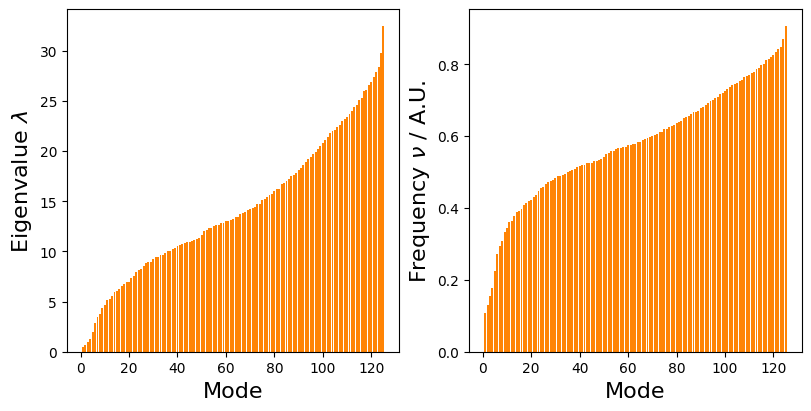

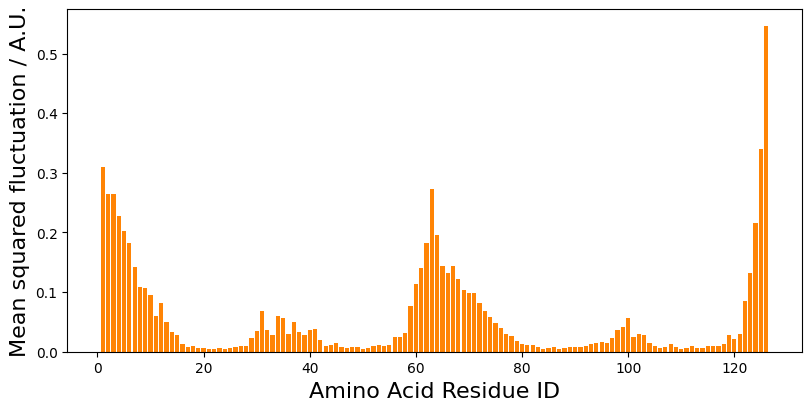

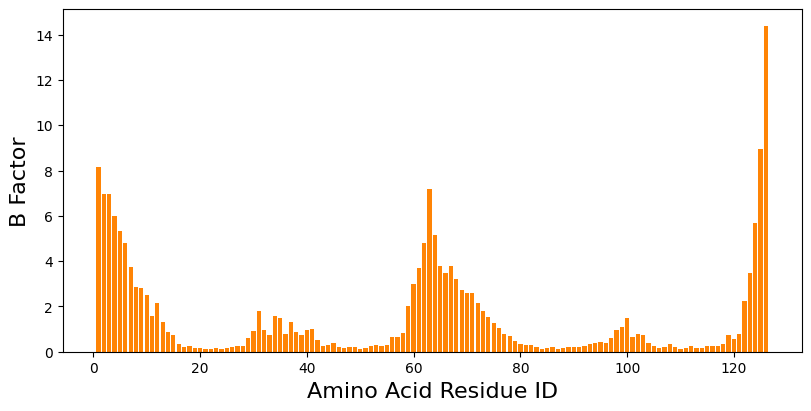

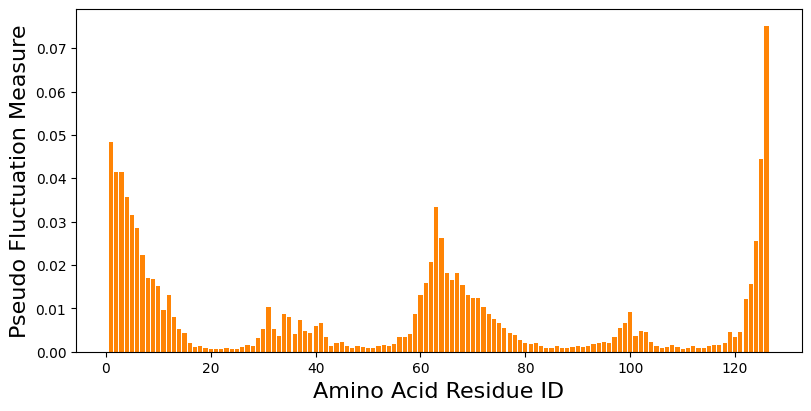

In [3]:
from src.SpringcraftNMA import plot_flexibility_value, plot_eigval_freq

plot_eigval_freq("1A0A", 10.0)
plot_flexibility_value("1A0A", 10.0, 10, "msqf")
plot_flexibility_value("1A0A", 10.0, 10, "bfact")
plot_flexibility_value("1A0A", 10.0, 10, "pseudo")

## Data Preparation for Training Phase

In [7]:
import torch
from src.DataProcessing import DataPreProcessorForGNM
x = DataPreProcessorForGNM(type_flexibility = "msqf")
torch.save(x.from_file("./1a0a.pdb"), "./data/preprocessed_data/1aar.pt")
torch.load("./data/preprocessed_data/bfact/0/1gqn_A.pt")

Data(x=[252, 3], edge_index=[2, 4594], y=[384], node_type=[252, 25], node_s=[252, 7], node_v=[252, 3, 3], edge_s=[4594, 32], edge_v=[4594, 1, 3], mask=[252])

## Loading Data

In [2]:
from libraries.lmdb_dataset import LMDBDataset

database = LMDBDataset("./data/pdb_data")
database

LMDBDataset(c:\Users\Mihailo\Desktop\Cambridge Part II\Part II Project\Part-II-Project-Protein-Dynamics-and-Flexibility\data\pdb_data)
	name:          pdb_data
	num_examples:  54,899
	size_on_disk:  3,648.76 MB

In [3]:
from src.DataLoaders import load_labels

labels = load_labels("./data/enzyme_data/chain_functions.txt")
len((labels["label"]).unique())


384

In [3]:
from src.DataProcessing import calculate_all_structures_and_store
import os

os.mkdir("./data/preprocessed_data")

os.mkdir("./data/preprocessed_data/msqf")
os.mkdir("./data/preprocessed_data/pseudo")
os.mkdir("./data/preprocessed_data/bfact")
os.mkdir("./data/preprocessed_data/no_flex")

for i in range(0,384):
    os.mkdir("./data/preprocessed_data/msqf/" + str(i))
    os.mkdir("./data/preprocessed_data/pseudo/" + str(i))
    os.mkdir("./data/preprocessed_data/bfact/" + str(i))
    os.mkdir("./data/preprocessed_data/no_flex/" + str(i))

calculate_all_structures_and_store(labels, database, "./data/preprocessed_data", None , "./data/enzyme_data/missing_resis.txt")
calculate_all_structures_and_store(labels, database, "./data/preprocessed_data", "msqf", "./data/enzyme_data/missing_resis.txt")
calculate_all_structures_and_store(labels, database, "./data/preprocessed_data", "bfact", "./data/enzyme_data/missing_resis.txt")
calculate_all_structures_and_store(labels, database, "./data/preprocessed_data", "pseudo", "./data/enzyme_data/missing_resis.txt")

 25%|██▌       | 6843/27371 [16:19<47:50,  7.15it/s]  C:\Users\Mihailo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\springcraft\nma.py:171: RuntimeWarning: divide by zero encountered in divide
  sq_div_eig_vectors = np.sum(eig_vectors/eig_values, axis=0)
C:\Users\Mihailo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\springcraft\nma.py:171: RuntimeWarning: invalid value encountered in divide
  sq_div_eig_vectors = np.sum(eig_vectors/eig_values, axis=0)
 25%|██▌       | 6844/27371 [17:21<40:43,  8.40it/s]  C:\Users\Mihailo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\springcraft\nma.py:171: RuntimeWarning: divide by zero encountered in divide
  sq_div_eig_vectors = np.sum(eig_vectors/eig_values, axis=0)
C:\Users\Mihailo\AppData\Local\Packages\PythonSoftwareFound

In [6]:
from tqdm import tqdm
from src.DataProcessing import  DataPreProcessorForGNM
from src.DataProcessing import check_chain
import biotite.structure as struc
exclude = "./data/enzyme_data/missing_resis.txt"
flex = "msqf"

for id in tqdm(set(labels.chain_id).difference(set(line.strip().replace("_",".") for line in open(exclude)))):
    PDBid, chain = id.split(".")
    if(PDBid in database):
        structure = database[PDBid]["structure"]
        x = DataPreProcessorForGNM(type_flexibility = flex)
        protein_chain = structure[(structure.chain_id == chain) & struc.filter_amino_acids(structure)] 
        if(check_chain(protein_chain)):
            p = x.from_loaded_structure(protein_chain, labels[labels["chain_id"] == id]["label"].iloc[0])
            break
p      

  2%|▏         | 500/27370 [01:26<1:31:27,  4.90it/s]

In [72]:
from src.DataLoaders import ProteinDataset

training_structures = ProteinDataset(labels, "./data/enzyme_data/training.txt", "msqf", "./data/enzyme_data/missing_resis.txt")
testing_structures = ProteinDataset(labels, "./data/enzyme_data/testing.txt", "msqf", "./data/enzyme_data/missing_resis.txt")
validating_structures = ProteinDataset(labels, "./data/enzyme_data/validation.txt", "msqf", "./data/enzyme_data/missing_resis.txt")

100%|██████████| 1353/1353 [00:09<00:00, 145.11it/s]


In [35]:
import torch
torch.load("./data/preprocessed_data/no_flex/62/1a0f_A.pt")

Data(x=[201, 3], edge_index=[2, 3276], y=[384], node_type=[201, 25], node_s=[201, 6], node_v=[201, 3, 3], edge_s=[3276, 32], edge_v=[3276, 1, 3], mask=[201])

In [73]:
print(len(training_structures))
print(len(testing_structures))
print(len(validating_structures))

21672
3099
1316


## Running Experiments

In [74]:
import time
import random
import numpy as np

import torch

from torch_geometric.loader import DataLoader


In [75]:
def seed(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed(0)

In [80]:
from torch.utils.data import Subset
train_loader = DataLoader(Subset(validating_structures, list(range(128,192))), batch_size=4, shuffle=False)
val_loader = DataLoader(Subset(validating_structures, list(range(128,192))), batch_size=4, shuffle=False)
test_loader = DataLoader(Subset(validating_structures, list(range(128,192))), batch_size=4, shuffle=False)

In [81]:
from src.Models import EGNNSiLUModel, EGNNReLUModel
from src.ExperimentUtils import run_experiment

model = EGNNSiLUModel(num_layers=4, emb_dim=64, in_dim=32, edge_dim=32, out_dim=384)
model_name = type(model).__name__
best_val_error, test_error, train_time, perf_per_epoch = run_experiment(
    model, 
    model_name, 
    train_loader,
    val_loader, 
    test_loader,
    n_epochs=100
)

model = EGNNReLUModel(num_layers=4, emb_dim=64, in_dim=32, edge_dim=32, out_dim=384)
model_name = type(model).__name__
best_val_error, test_error, train_time, perf_per_epoch = run_experiment(
    model, 
    model_name, 
    train_loader,
    val_loader, 
    test_loader,
    n_epochs=100
)

Running experiment for EGNNSiLUModel, training on 64 samples for 100 epochs.

Device:
GPU

Model architecture:
EGNNSiLUModel(
  (lin_in): Linear(in_features=32, out_features=64, bias=True)
  (convs): ModuleList(
    (0): EGNNSiLULayer(emb_dim=64, aggr=add)
    (1): EGNNSiLULayer(emb_dim=64, aggr=add)
    (2): EGNNSiLULayer(emb_dim=64, aggr=add)
    (3): EGNNSiLULayer(emb_dim=64, aggr=add)
  )
  (lin_pred): Linear(in_features=64, out_features=384, bias=True)
)
Total parameters: 178628

Start training:
Epoch: 010, LR: 0.001000, Loss: 1.2468994, Val Accuracy: 0.2812500, Test Accuracy: 0.2812500


KeyboardInterrupt: 

In [12]:
from src.testing.UnitTests import permutation_equivariance_unit_test, permutation_invariance_unit_test, rot_trans_invariance_unit_test, rot_trans_equivariance_unit_test
from src.Models import EGNNReLUModel, EGNNSiLUModel, EGNNReLULayer, EGNNSiLULayer

# Instantiate temporary model, layer, and dataloader for unit testing
layer = EGNNReLULayer(emb_dim=32, edge_dim=32)
model = EGNNReLUModel(num_layers=4, emb_dim=64, in_dim=32, edge_dim=32, out_dim=384)
dataloader = DataLoader(validating_structures[:64], batch_size=1, shuffle=True)

# Permutation invariance unit test for MPNN model
print(f"Is {type(model).__name__} permutation invariant? --> {permutation_invariance_unit_test(model, dataloader)}!")

# Permutation equivariance unit for MPNN layer
print(f"Is {type(layer).__name__} permutation equivariant? --> {permutation_equivariance_unit_test(layer, dataloader)}!")

# Rotation and translation invariance unit test for MPNN model
print(f"Is {type(model).__name__} rotation and translation invariant? --> {rot_trans_invariance_unit_test(model, dataloader)}!")

# Rotation and translation invariance unit test for MPNN layer
print(f"Is {type(layer).__name__} rotation and translation equivariant? --> {rot_trans_equivariance_unit_test(layer, dataloader)}!")

# Instantiate temporary model, layer, and dataloader for unit testing
layer = EGNNSiLULayer(emb_dim=32, edge_dim=32)
model = EGNNSiLUModel(num_layers=4, emb_dim=64, in_dim=32, edge_dim=32, out_dim=384)
dataloader = DataLoader(validating_structures[:64], batch_size=1, shuffle=True)

# Permutation invariance unit test for MPNN model
print(f"Is {type(model).__name__} permutation invariant? --> {permutation_invariance_unit_test(model, dataloader)}!")

# Permutation equivariance unit for MPNN layer
print(f"Is {type(layer).__name__} permutation equivariant? --> {permutation_equivariance_unit_test(layer, dataloader)}!")

# Rotation and translation invariance unit test for MPNN model
print(f"Is {type(model).__name__} rotation and translation invariant? --> {rot_trans_invariance_unit_test(model, dataloader)}!")

# Rotation and translation invariance unit test for MPNN layer
print(f"Is {type(layer).__name__} rotation and translation equivariant? --> {rot_trans_equivariance_unit_test(layer, dataloader)}!")

Is EGNNReLUModel permutation invariant? --> True!
Is EGNNReLULayer permutation equivariant? --> True!
Is EGNNReLUModel rotation and translation invariant? --> True!
Is EGNNReLULayer rotation and translation equivariant? --> True!
Is EGNNSiLUModel permutation invariant? --> True!
Is EGNNSiLULayer permutation equivariant? --> True!
Is EGNNSiLUModel rotation and translation invariant? --> True!
Is EGNNSiLULayer rotation and translation equivariant? --> True!
